In [2]:
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
import mido
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
def obtain_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    inputs = torch.tensor(data['notes'])
    targets = torch.tensor(data['notes_corrected'])
    return inputs, targets

RawData = obtain_data('train.json')

In [4]:
Data = obtain_data("train.json")

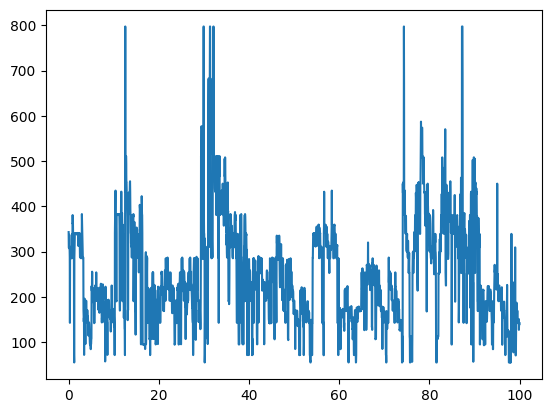

In [5]:
X = np.linspace(start=0,stop=100,num=len(Data[0]))
Y = Data[0][:][:].T[2]
plt.plot(X,Y)

In [6]:
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
import mido
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pretty_midi

def midi_to_pianoroll(path, fs=100, normalize=False):
    """
    Load a MIDI file and return a piano-roll numpy array and the time axis.
    - path: path to .mid file
    - fs: frames per second (time resolution)
    - normalize: if True, scale velocities to [0,1]
    Returns:
    - piano_roll: shape (T, 128), dtype float32 (T = number of time frames)
    - times: shape (T,), time in seconds for each frame
    """
    pm = pretty_midi.PrettyMIDI(path)
    pr = pm.get_piano_roll(fs=fs)  # shape (128, T), values = velocities (0-127)
    pr = pr.T.astype(np.float32)   # convert to (T, 128)
    if normalize:
        maxv = pr.max() if pr.max() > 0 else 1.0
        pr = pr / maxv
    times = np.linspace(0, pm.get_end_time(), pr.shape[0])
    return pr, times

piano_roll, times = midi_to_pianoroll('Bach_test.mid', fs=100, normalize=True)
# print((piano_roll).shape, times)


def makeThemNotes(Piece):
    NotePerDuation = []
    for piano_rolls in Piece:
        note_played = 128 # in this case we label the note 128 as no notes are being played
        for i in range(len(piano_rolls)):
            note = piano_rolls[i]
            if note > 0:
                note_played = i
        NotePerDuation.append(note_played)
    return NotePerDuation

def DataToTrain(Notes,size_of_the_window):
    # we will perform a sliding window algorithm to solve the problem
    final_data = []
    final_target_data = []
    for i in range(len(Notes) - size_of_the_window):
        window = []
        for j in range(size_of_the_window):
            window.append(Notes[i+j])
        final_data.append(window)
        if i < (len(Notes) - size_of_the_window - 1):
            final_target_data.append(Notes[i+size_of_the_window])
        else:
            final_target_data.append(Notes[len(Notes) - 1])
    return final_data,final_target_data




In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.to(device)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last_out = out[:, -1, :]
        prediction = self.fc(last_out)
        return prediction

class LSTMDataset(Dataset):
    def __init__(self, data, target, device):
        self.data = torch.tensor(np.vstack(data), dtype=torch.float32).unsqueeze(-1).to(device)
        self.target = torch.tensor(target, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.target[index]


Using device: cuda


In [47]:
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
import mido
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pretty_midi
from Model_LSTM import LSTMModel,LSTMDataset
from helper_LSTM import DataToTrain,makeThemNotes,midi_to_pianoroll

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

piano_roll, times = midi_to_pianoroll('Bach_test.mid',fs=1)
Notes = makeThemNotes(piano_roll)
RawData_ready_to_train = DataToTrain(Notes,64)

Compressed_data_train = RawData_ready_to_train[0]
Compressed_data_target = RawData_ready_to_train[1]

for i in range(len(Compressed_data_train)):
    for j in range(len(Compressed_data_train[i])):
        Compressed_data_train[i][j] = Compressed_data_train[i][j] / 128

Compressed_data_target_int = [int(t) for t in Compressed_data_target]
BATCH_SIZE = 10

DataSet_LSTM_BACH = LSTMDataset(Compressed_data_train, Compressed_data_target_int, device)
DataLoader_LSTM_BACH = DataLoader(DataSet_LSTM_BACH, batch_size=BATCH_SIZE)

Using device: cuda


In [53]:
for data, target in DataLoader_LSTM_BACH:
    print(data.shape)
print("dataset")
for data,target in DataSet_LSTM_BACH:
    print(data.shape)

torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([10, 64, 1])
torch.Size([5, 64, 1])
dataset
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Siz